In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# 1. Load and prepare data with error handling
def load_data(file_path):
    df = pd.read_csv(file_path, dayfirst=True)
    df["Date"] = pd.to_datetime(df["Date"], format="%d-%b-%y")
    
    # Clean Change column - handle hyphens and percentages
    df['Change'] = df['Change'].replace('-', '0%')  # Replace hyphens with 0%
    df['Change'] = df['Change'].str.replace('%', '').astype(float) / 100
    
    # Clean Volume column - remove commas
    df['Volume'] = df['Volume'].str.replace(',', '').astype(float)
    
    return df.set_index('Date').sort_index()

# Load your NVIDIA stock data
try:
    stock_data = load_data('nvidia-stocks.csv')
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()
except Exception as e:
    print(f"Error loading data: {e}")
    exit()


In [31]:
# 2. Create target and features
stock_data['target'] = stock_data['Close'].shift(-1)
stock_data.dropna(inplace=True)
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change']
X = stock_data[features]
y = stock_data['target']

# 3. Normalize data
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))


In [32]:
# 4. Train/test split
train_size = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]


In [33]:
# 5. Create sequences
n_input = 30  # Lookback window
n_features = len(features)

def create_sequences(X, y):
    X_seq, y_seq = [], []
    for i in range(len(X) - n_input):
        X_seq.append(X[i:i+n_input])
        y_seq.append(y[i+n_input])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train, y_train)
X_test_seq, y_test_seq = create_sequences(X_test, y_test)


In [34]:
# 6. Build and train model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(n_input, n_features)),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=200,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)


Epoch 1/200


d:\python\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0234 - val_loss: 7.0143
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0056 - val_loss: 6.2828
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0052 - val_loss: 6.3738
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0039 - val_loss: 5.8652
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0033 - val_loss: 5.6139
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0026 - val_loss: 5.5553
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0025 - val_loss: 5.3839
Epoch 8/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0024 - val_loss: 5.1615
Epoch 9/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0022 - val_loss: 5.6129
Epoch 10/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0019 - val_loss: 5.3328
Epoch 11/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0021 - val_loss: 5.3570
Epoch 12/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0

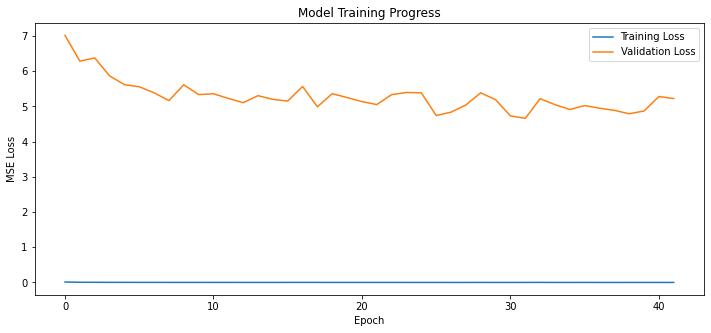

In [35]:
# 7. Plot training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Progress')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [15]:
# 8. Make prediction for next day
last_sequence = X_scaled[-n_input:]  # Use most recent data
next_day_pred = model.predict(last_sequence.reshape(1, n_input, n_features))
next_day_close = scaler_y.inverse_transform(next_day_pred)[0][0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


In [16]:
# 9. Plot actual vs predicted
test_predictions = model.predict(X_test_seq)
test_predictions = scaler_y.inverse_transform(test_predictions)
y_test_actual = scaler_y.inverse_transform(y_test_seq)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


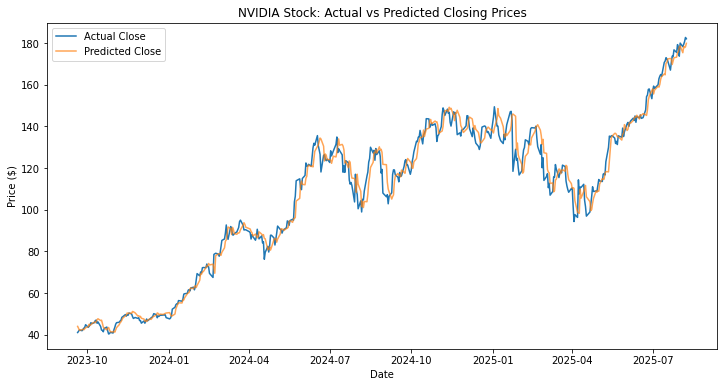

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index[train_size+n_input:], y_test_actual, label='Actual Close')
plt.plot(stock_data.index[train_size+n_input:], test_predictions, label='Predicted Close', alpha=0.7)
plt.title('NVIDIA Stock: Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


In [23]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test_actual, test_predictions)

print(f"R² (Train): {r2:.4f}")


R² (Train): 0.9808
